<a href="https://colab.research.google.com/github/Timmmtech/Pytorch-Basics/blob/main/Feedforward_DeepNeuralNetwork_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Download Dataset

In [2]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_ds = FashionMNIST(root='data/', train=False, transform=ToTensor())


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.2MB/s]


In [3]:
## Define validation and training dataset
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

## Create Pytorch DataLoader

In [4]:
batch_size = 128

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


images.shape: torch.Size([128, 1, 28, 28])


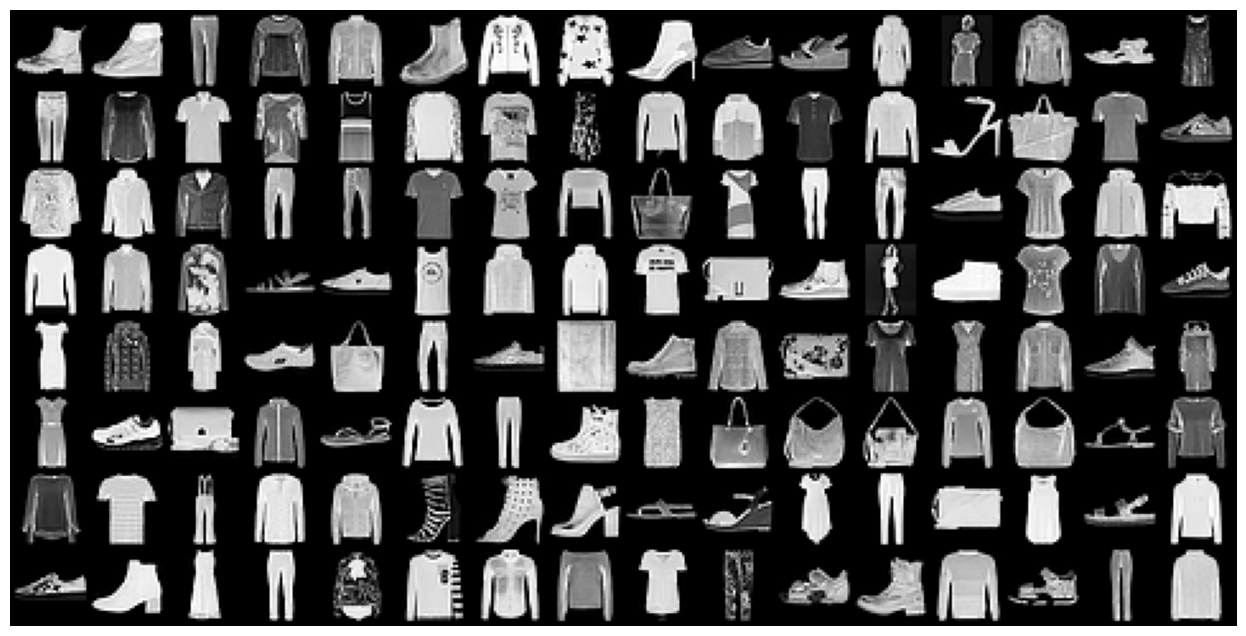

In [6]:
## visualize a batch of data
for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
  break

## Model
The model will be defined by extending the nn.Module class from pytorch

In [7]:
class FashionMnistModel(nn.Module):
  """Feedforward neural network with 2 hidden layers"""

  def __init__(self, in_size, hidden_size1, hidden_size2, out_size):
    super().__init__()
    # Hidden Layer1
    self.linear1 = nn.Linear(in_size, hidden_size1)
    # hidden layer2
    self.linear2 = nn.Linear(hidden_size1, hidden_size2)
    # outputs layer
    self.linear3 = nn.Linear(hidden_size2, out_size)

  def forward(self, xb):
    # Flatten the image tensors
    xb = xb.view(xb.size(0), -1)
    # Get intermediate outputs using hidden layer1
    out = self.linear1(xb)
    # Apply activation function
    out = torch.relu(out)
    # Get intermediate output and apply activation function
    out = self.linear2(out)
    out = torch.relu(out)
    # Get predictions using output layer
    out = self.linear3(out)
    return out

  def training_step(self, batch):
    """Returns a loss for a batch of Training data"""
    images, labels = batch
    out = self(images)  # Get predictions
    loss = F.cross_entropy(out, labels)  # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()

    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()

    return {'val_loss': epoch_loss.item(),
            'val_acc': epoch_acc.item()
    }

  def epoch_end(self, epoch, result):
    print(
        f"Epoch [{epoch}], "
        f"val_loss: {result['val_loss']:.4f}, "
        f"val_acc: {result['val_acc']:.4f}"
    )

In [8]:
## Define Accuracy Function
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
## define the hidden layer
input_size = 784
hidden_size1 = 16
hidden_size2 = 32
num_classes = 10

In [10]:
#create the model
model = FashionMnistModel(input_size, hidden_size1=16, hidden_size2=32, out_size=num_classes)

In [11]:
for t in model.parameters():
  print(t.shape)

torch.Size([16, 784])
torch.Size([16])
torch.Size([32, 16])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
## Generate output with the model
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break

print('outputs.shape:', outputs.shape)
print('Sample outputs :/n', outputs[:2].data)

Loss: 2.2957544326782227
outputs.shape: torch.Size([128, 10])
Sample outputs :/n tensor([[-0.1448,  0.0309,  0.1043,  0.1384,  0.0163,  0.0819,  0.0595, -0.1730,
         -0.1577,  0.0947],
        [-0.1210,  0.0155,  0.0820,  0.1116,  0.0483,  0.0886,  0.0499, -0.1513,
         -0.1453,  0.0734]])


## Set GPU

In [14]:
torch.cuda.is_available()

True

In [15]:
## Create pipelines to move GPU
from torch.cuda import is_available
## Helper function for GPU
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
## Define a function that can move data to chosen device
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [18]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


torch.Size([128, 1, 28, 28])
cuda:0


In [19]:
## Define a DeviceDataLoader to wrap existing dataloader and move batches of data to selected device
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)




In [20]:
## wrap dataloader using DeviceDataLoader
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [21]:
## verify its moved successfully
for xb, yb in val_loader:
  print('xb.device:', xb.device)
  print('yb:', yb)
  break

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


xb.device: cuda:0
yb: tensor([8, 9, 6, 2, 0, 0, 6, 6, 4, 9, 4, 1, 9, 2, 4, 1, 9, 5, 6, 1, 0, 9, 0, 5,
        2, 2, 0, 5, 4, 7, 0, 6, 8, 5, 5, 8, 6, 2, 2, 8, 5, 3, 7, 1, 3, 6, 4, 7,
        5, 4, 9, 5, 6, 9, 6, 4, 0, 0, 7, 9, 7, 0, 8, 6, 3, 4, 6, 0, 3, 6, 4, 2,
        1, 1, 4, 1, 7, 7, 8, 7, 1, 3, 1, 1, 7, 1, 3, 7, 8, 8, 2, 8, 9, 3, 6, 8,
        0, 7, 8, 2, 4, 7, 3, 1, 2, 6, 9, 4, 8, 2, 1, 2, 3, 0, 8, 7, 9, 8, 8, 6,
        9, 1, 2, 5, 2, 4, 0, 0, 9, 5, 3, 4, 3, 6, 9, 9, 6, 5, 1, 5, 4, 2, 5, 3,
        3, 8, 0, 9, 2, 2, 0, 7, 2, 6, 0, 1, 0, 9, 2, 5, 2, 5, 3, 4, 9, 4, 4, 6,
        4, 4, 9, 2, 2, 4, 7, 5, 9, 2, 2, 8, 7, 6, 3, 1, 9, 5, 7, 5, 2, 9, 6, 0,
        6, 7, 5, 1, 9, 9, 3, 5, 7, 9, 6, 1, 4, 1, 5, 0, 9, 2, 3, 6, 4, 1, 6, 3,
        8, 0, 2, 2, 5, 3, 5, 1, 6, 5, 4, 6, 2, 6, 9, 9, 1, 0, 7, 6, 1, 9, 6, 6,
        1, 2, 6, 0, 9, 1, 8, 3, 3, 2, 2, 2, 4, 8, 5, 1], device='cuda:0')


## Training the Model
create 2 functions 'fit', 'evaluate'. These functions will be used to train the model using gradient descent and to al evaluate its performance on validation set

In [49]:
def evaluate(model, val_loader):
  """Evaluate the model's performance on the validatio set"""
  model.eval()  # Switch to evaluation mode

  outputs = []
  with torch.no_grad():    # Disable gradient tracking
    for batch in val_loader:
      outputs.append(model.validation_step(batch))

  return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  """Train the model using gradient descent"""
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #Training Phase
    model.train()  # switch to training mode
    train_losses_batch = []
    train_accuracies_batch = []
    for batch in train_loader:
      images, labels = batch
      loss = model.training_step(batch) # Use existing training_step for loss

      out = model(images) # Rerun forward pass for accuracy
      acc = accuracy(out, labels)

      train_losses_batch.append(loss.item())
      train_accuracies_batch.append(acc.item())

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    avg_train_loss = torch.tensor(train_losses_batch).mean().item()
    avg_train_acc = torch.tensor(train_accuracies_batch).mean().item()

    # Validation Phase
    result_val = evaluate(model, val_loader)

    epoch_result = {
        'loss': avg_train_loss,
        'acc': avg_train_acc,
        'val_loss': result_val['val_loss'],
        'val_acc': result_val['val_acc']
    }

    model.epoch_end(epoch, epoch_result)
    history.append(epoch_result)

  return history

In [44]:
## verify model and parameters are on same device
model = FashionMnistModel(input_size, hidden_size1=16, hidden_size2=32, out_size=num_classes)
to_device(model, device)

FashionMnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [45]:
## Check how model perform on validation set before training
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.304938316345215, 'val_acc': 0.10312499850988388}]

In [46]:
history += fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7005, val_acc: 0.7506
Epoch [1], val_loss: 0.6077, val_acc: 0.7666
Epoch [2], val_loss: 0.5350, val_acc: 0.8057
Epoch [3], val_loss: 0.5147, val_acc: 0.8062
Epoch [4], val_loss: 0.5440, val_acc: 0.8043
Epoch [5], val_loss: 0.4346, val_acc: 0.8461
Epoch [6], val_loss: 0.4460, val_acc: 0.8337
Epoch [7], val_loss: 0.4325, val_acc: 0.8433
Epoch [8], val_loss: 0.4302, val_acc: 0.8482
Epoch [9], val_loss: 0.4193, val_acc: 0.8478


In [47]:
history += fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3903, val_acc: 0.8574
Epoch [1], val_loss: 0.3895, val_acc: 0.8583
Epoch [2], val_loss: 0.3912, val_acc: 0.8589
Epoch [3], val_loss: 0.3912, val_acc: 0.8564
Epoch [4], val_loss: 0.3945, val_acc: 0.8580
Epoch [5], val_loss: 0.3862, val_acc: 0.8600
Epoch [6], val_loss: 0.3888, val_acc: 0.8579
Epoch [7], val_loss: 0.3839, val_acc: 0.8582
Epoch [8], val_loss: 0.3841, val_acc: 0.8615
Epoch [9], val_loss: 0.3867, val_acc: 0.8604


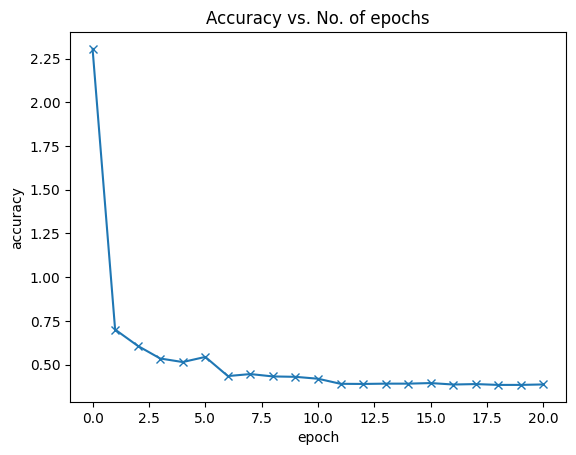

In [54]:
## Plot the losses and accuracies
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


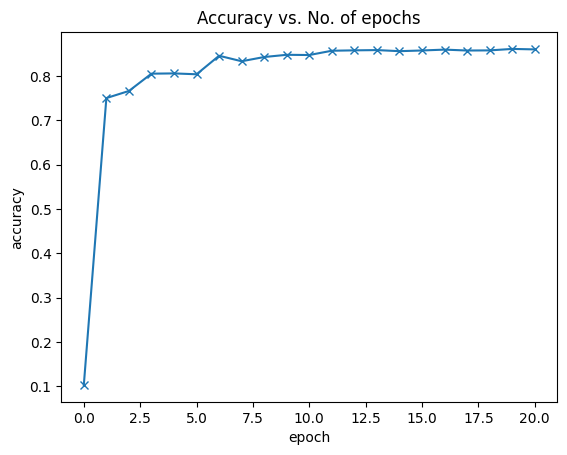

In [55]:

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Test with individual images

In [57]:
## Helper function to predict image
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: 9 , Predicted: 9


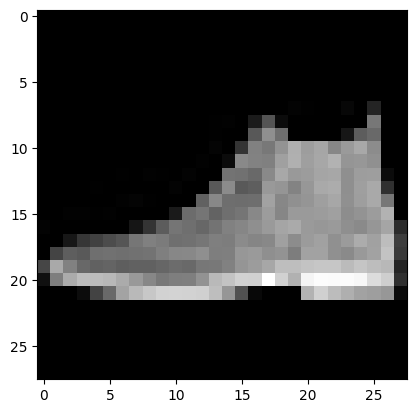

In [59]:
img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


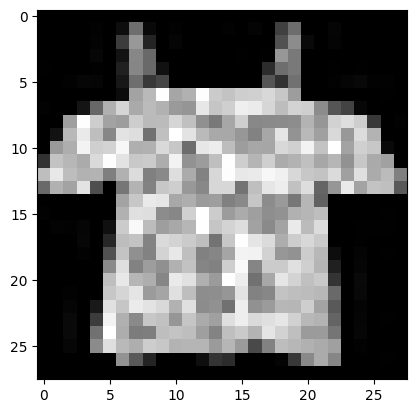

In [61]:
img, label = test_ds[183]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


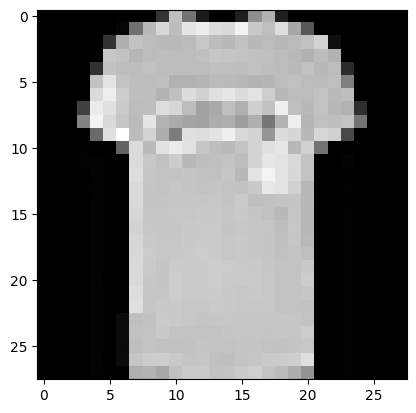

In [63]:
img, label = test_ds[19]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 4 , Predicted: 4


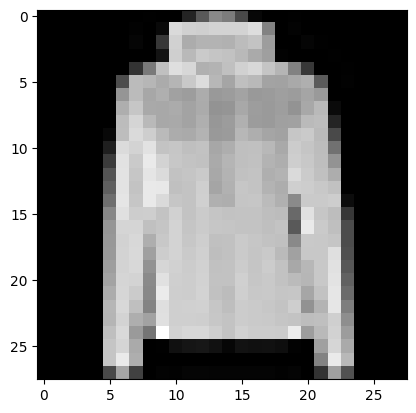

In [64]:
img, label = test_ds[987]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [66]:
## overall loss and accuracy on test set
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.41249045729637146, 'val_acc': 0.8573242425918579}